# AI허브 건강관리를 위한 음식 이미지

In [ ]:
!nvidia-smi

Thu May 26 04:16:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import random
# root_dir = '/content/drive/MyDrive/Final/inception'
# base_dir = os.path.join(root_dir, 'healthy_food')
root_dir = './'
base_dir = os.path.join(root_dir, 'data')
split_dir = {split_name:os.path.join(base_dir,split_name)
                for split_name in ['train','valid','test']}
os.chdir(root_dir)
random.seed = 42

In [ ]:
!unzip -qq healthy_food.zip

## Modeling

In [ ]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, Input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers, regularizers, optimizers
print(tf.__version__)

2.8.0


In [ ]:
!python --version

Python 3.7.13


## Make Generator

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255) 

train_generator = train_datagen.flow_from_directory(
    split_dir['train'],
    target_size = (299, 299),
    batch_size = 32,
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    split_dir['valid'],
    target_size = (299, 299),
    batch_size = 32,
    shuffle=True,
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    split_dir['test'],
    target_size = (299, 299),
    batch_size = 32,
    seed = 42
)

Found 81055 images belonging to 422 classes.
Found 23535 images belonging to 422 classes.
Found 11133 images belonging to 422 classes.


In [5]:
for data_batch, labels_batch in train_generator:
    print('Batch data size:', data_batch.shape)
    print('Batch label size:', labels_batch.shape)
    break
print('Generator length:', len(train_generator))

Batch data size: (32, 299, 299, 3)
Batch label size: (32, 422)
Generator length: 2533


## Set Checkpoint Path

In [ ]:
from datetime import datetime
now = datetime.now().strftime('%y%m%d_%H%M%S')

model_dir = os.path.join(base_dir, 'model')
save_dir = os.path.join(model_dir, now)

if not(os.path.isdir(model_dir)):
    os.mkdir(model_dir)
os.mkdir(save_dir)

model_path = save_dir + '/{epoch:02d}-{val_acc:.4f}.hdf5'

## Add Output Layer

In [ ]:
import sys
sys.setrecursionlimit(10000)
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
# base_model.trainable = False
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.2)(x)
x = Flatten()(x)
x = Dropout(.2)(x)
predictions = layers.Dense(422,kernel_initializer='glorot_uniform', 
                        kernel_regularizer=regularizers.l2(.0005), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

87924736/87910968 [==============================] - 0s 0us/step


## Load Checkpoint

In [ ]:
# from tensorflow.keras import models
# model = models.load_model('./04-0.4752.hdf5')

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)

In [ ]:
def schedule(epoch):
    if epoch < 5:
        return .01
    elif epoch < 8:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

## Train

In [ ]:
history2 = model.fit_generator(train_generator,
                    epochs=3, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping, lr_scheduler]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/3
2533/2533 [==============================] - ETA: 0s - loss: 5.9721 - accuracy: 0.0494
Epoch 1: val_accuracy improved from -inf to 0.23773, saving model to /content/drive/MyDrive/model결과 : 01-0.2377.hdf5
2533/2533 [==============================] - 2158s 845ms/step - loss: 5.9721 - accuracy: 0.0494 - val_loss: 4.8911 - val_accuracy: 0.2377 - lr: 0.0100
Epoch 2/3
2533/2533 [==============================] - ETA: 0s - loss: 4.8465 - accuracy: 0.1600
Epoch 2: val_accuracy improved from 0.23773 to 0.32301, saving model to /content/drive/MyDrive/model결과 : 02-0.3230.hdf5
2533/2533 [==============================] - 2074s 819ms/step - loss: 4.8465 - accuracy: 0.1600 - val_loss: 4.1012 - val_accuracy: 0.3230 - lr: 0.0100
Epoch 3/3
 691/2533 [=======>......................] - ETA: 23:35 - loss: 4.4255 - accuracy: 0.2124

In [ ]:
history3 = model.fit_generator(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping, lr_scheduler]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/5
2533/2533 [==============================] - ETA: 0s - loss: 3.9398 - accuracy: 0.2723
Epoch 1: val_accuracy improved from 0.36894 to 0.39358, saving model to /content/drive/MyDrive/model결과 : 01-0.3936.hdf5
2533/2533 [==============================] - 2074s 818ms/step - loss: 3.9398 - accuracy: 0.2723 - val_loss: 3.4290 - val_accuracy: 0.3936 - lr: 0.0100
Epoch 2/5
2533/2533 [==============================] - ETA: 0s - loss: 3.7253 - accuracy: 0.2999
Epoch 2: val_accuracy improved from 0.39358 to 0.41576, saving model to /content/drive/MyDrive/model결과 : 02-0.4158.hdf5
2533/2533 [==============================] - 2064s 815ms/step - loss: 3.7253 - accuracy: 0.2999 - val_loss: 3.2602 - val_accuracy: 0.4158 - lr: 0.0100
Epoch 3/5
2533/2533 [==============================] - ETA: 0s - loss: 3.5691 - accuracy: 0.3245
Epoch 3: val_accuracy improved from 0.41576 to 0.43157, saving model to /content/drive/MyDrive/model결과 : 03-0.4316.hdf5
2533/2533 [==============================] - 20

In [ ]:
history = model.fit_generator(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping, lr_scheduler]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/5
2533/2533 [==============================] - ETA: 0s - loss: 3.3736 - accuracy: 0.3539
Epoch 1: val_accuracy improved from -inf to 0.45294, saving model to /content/drive/MyDrive/Final/inception/model_2022_5_26_10h/01-0.4529.hdf5
2533/2533 [==============================] - 2123s 832ms/step - loss: 3.3736 - accuracy: 0.3539 - val_loss: 2.9819 - val_accuracy: 0.4529 - lr: 0.0100
Epoch 2/5
2533/2533 [==============================] - ETA: 0s - loss: 3.3003 - accuracy: 0.3678
Epoch 2: val_accuracy improved from 0.45294 to 0.46021, saving model to /content/drive/MyDrive/Final/inception/model_2022_5_26_10h/02-0.4602.hdf5
2533/2533 [==============================] - 2088s 824ms/step - loss: 3.3003 - accuracy: 0.3678 - val_loss: 2.9265 - val_accuracy: 0.4602 - lr: 0.0100
Epoch 3/5
2533/2533 [==============================] - ETA: 0s - loss: 3.2366 - accuracy: 0.3794
Epoch 3: val_accuracy improved from 0.46021 to 0.46713, saving model to /content/drive/MyDrive/Final/inception/model_2

## Show History

In [ ]:
history.history

In [2]:
history = dict()
history['accuracy'] = [0.0494, 0.1600, 0.2723, 0.2999, 0.3245, 0.3388, 0.3539, 0.3678, 0.3794, 0.3851]
history['val_accuracy'] = [0.2377, 0.3230, 0.3936, 0.4158, 0.4316, 0.4417, 0.4529, 0.4602, 0.4671, 0.4752]
history['loss'] = [5.9721, 4.8465, 3.9398, 3.7253, 3.5691, 3.4631, 3.3736, 3.3003, 3.2366, 3.1943]
history['val_loss'] = [4.8911, 4.1012, 3.4290, 3.2602, 3.1393, 3.0506, 2.9819, 2.9265, 2.8823, 2.8390]

In [3]:
import pandas as pd

pd.DataFrame(history)

,accuracy,val_accuracy,loss,val_loss
0,0.0494,0.2377,5.9721,4.8911
1,0.1600,0.3230,4.8465,4.1012
2,0.2723,0.3936,3.9398,3.4290
3,0.2999,0.4158,3.7253,3.2602
4,0.3245,0.4316,3.5691,3.1393
5,0.3388,0.4417,3.4631,3.0506
6,0.3539,0.4529,3.3736,2.9819
7,0.3678,0.4602,3.3003,2.9265
8,0.3794,0.4671,3.2366,2.8823
9,0.3851,0.4752,3.1943,2.8390


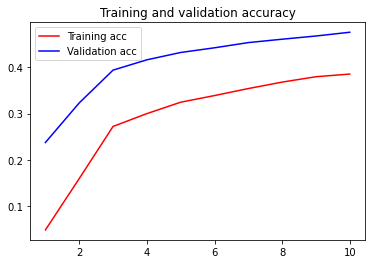

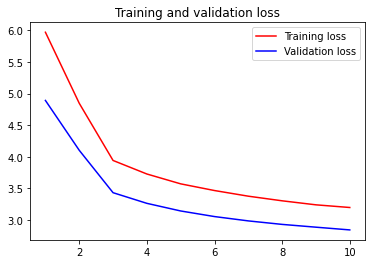

In [4]:
import matplotlib.pyplot as plt

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Save Model

In [ ]:
model.save('best_model.h5')